In [1]:
using MLDataPattern
using ProgressMeter
using Plots
pyplot()

Plots.PyPlotBackend()

In [4]:
include("pympc.jl")

Test Summary:    | Pass  Total
test sensitivity |  267    267


PyMPC

In [26]:
mass = 1.
l = 1.
g = 10.
N = 4
# A = [0. 1.;
#      g/l 0.]
# B = [0 1/(mass*l^2.)]'
A = [0. 1; 0 0]
B = [0. 1]'
Δt = .1
pysys = PyMPC.dynamical_systems.DTLinearSystem[:from_continuous](A, B, Δt)

# x_max = [pi/6, pi/20/(N*Δt)]
x_max = [1., 1]
x_min = -x_max
# u_max = [mass*g*l*pi/8.]
u_max = [1.]
u_min = -u_max
times = 0:Δt:N*Δt

Q = 10 * eye(2)
R = eye(1)

X_bounds = PyMPC.geometry.Polytope[:from_bounds](reshape(x_min, 2, 1), reshape(x_max, 2, 1))[:assemble]()
U_bounds = PyMPC.geometry.Polytope[:from_bounds](reshape(u_min, 1, 1), reshape(u_max, 1, 1))[:assemble]()
controller = PyMPC.control.MPCController(pysys, N, "two", Q, R, X=X_bounds, U=U_bounds)

qp = controller[:condensed_program]

data = Vector{Tuple{Vector{Float64}, Vector{Float64}}}()

while length(data) < 1000
    x = x_min + rand(length(x_min)) .* (x_max - x_min)
    status, u, J = PyMPC.solve_qp(qp, x)
    if status == :Optimal
        push!(data, (x, vcat(u[1, :], J[1, :])))
    end
end

train_data, test_data = splitobs(data, 0.5);

In [27]:
include("nets.jl")

Test Summary: | Pass  

Total
feedforward   |  200    200
Test Summary: | Pass  Total
random shapes |  392    392
Test Summary:     | Pass  Total
compiled jacobian | 1000   1000


Nets

In [38]:
shapes = [(4, 2), (4, 4), (4, 4), (1, 4)]
net = Nets.Net(shapes)
params = 2 * (rand(net) .- 0.5)

predict = (params, x) -> Nets.predict_sensitivity(net, params, x)
loss = (params, x, y) -> sum(abs2, y - predict(params, x))

losses = Float64[]

@showprogress for i in 1:20
    Nets.sgd!(loss, params, train_data, 
        Nets.SGDOpts(learning_rate=0.1, momentum=0.0, 
            batch_size=20))
    push!(losses, mean(xy -> loss(params, xy[1], xy[2]), test_data))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18



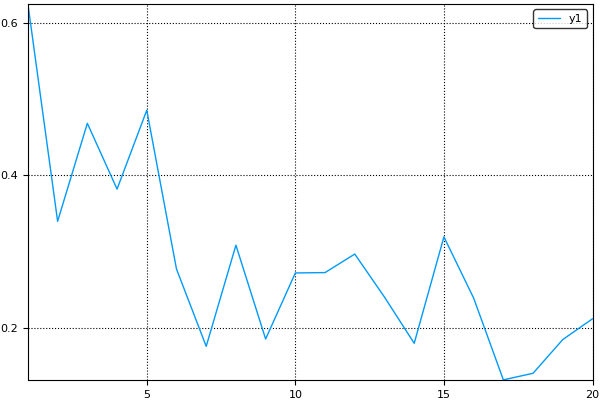

In [39]:
plot(losses)


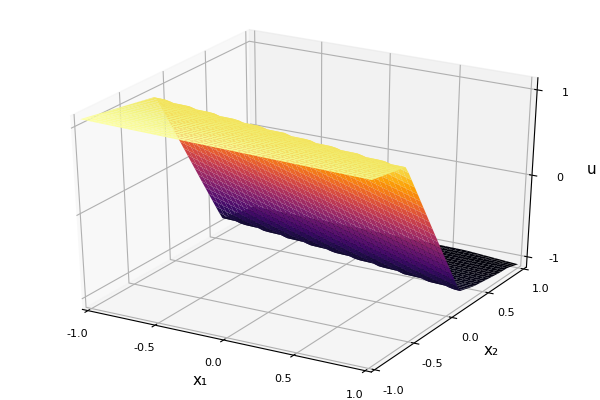

In [40]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> predict(params, [x, y])[1], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)
plt

In [37]:
gui()

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:51
 [3] indices at ./abstractarray.jl:57 [inlined]
 [4] indices1 at ./abstractarray.jl:64 [inlined]
 [5] linearindices at ./abstractarray.jl:92 [inlined]
 [6] endof at ./abstractarray.jl:127 [inlined]
 [7] optimize_ticks_typed(::Float64, ::Float64, ::Bool, ::Array{Tuple{Float64,Float64},1}, ::Int64, ::Int64, ::Int64, ::Float64, ::Float64, ::Float64, ::Float64, ::Bool, ::Void) at /Users/rdeits/.julia/v0.6/PlotUtils/src/ticks.jl:162
 [8] (::PlotUtils.#kw##optimize_ticks)(::Array{Any,1}, ::PlotUtils.#optimize_ticks, ::Float64, ::Float64) at ./<missing>:0
 [9] optimal_ticks_and_labels(::Plots.Axis, ::Void) at /Users/rdeits/.julia/v0.6/Plots/src/axes.jl:185
 [10] get_ticks(::Plots.Axis) at /Users/rdeits/.julia/v0.6/Plots/src/axes.jl:228
 [11] _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at /Users/rdeits/.julia/v0.6/Plots/src/backends/pyplot.jl:1047
 [12] prep


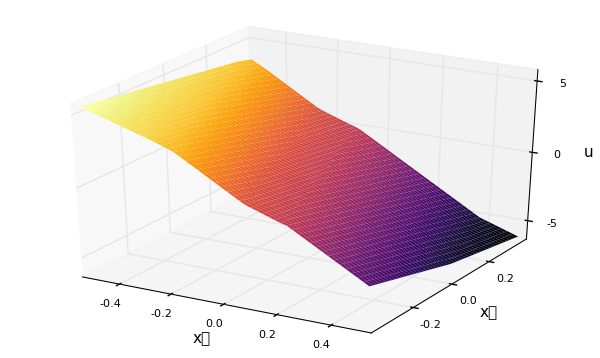

In [72]:
mx_params = vec(readdlm("weights.csv"))
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> predict(mx_params, [x, y])[1], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)
plt

In [66]:
gui()